In [ ]:
import cv2
import numpy as np
import os
from scipy.interpolate import griddata
import pickle

data = {}
epsilon = 1e-8
N = 300

number_iter = 1600

psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)

# Define the azimuthal average function
def azimuthal_average(image):
    cy, cx = np.array(image.shape) // 2
    y, x = np.indices(image.shape)
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    r_bins = np.arange(0, image.shape[0] // 2 + 1, 1)

    radial_sum = np.zeros_like(r_bins[:-1], dtype=float)
    radial_count = np.zeros_like(r_bins[:-1], dtype=int)

    for i in range(len(r_bins) - 1):
        mask = (r >= r_bins[i]) & (r < r_bins[i + 1])
        radial_sum[i] = np.sum(image[mask])
        radial_count[i] = np.sum(mask)

    radial_avg = radial_sum / (radial_count + 1e-8)
    return radial_avg

cont = 0

# fake data
rootdir = '/content/drive/MyDrive/Colab Notebooks/prepro_deepFake/fake'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filename = os.path.join(subdir, file)

        img = cv2.imread(filename, 0)

        # we crop the center
        h = int(img.shape[0] / 3)
        w = int(img.shape[1] / 3)
        img = img[h:-h, w:-w]

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)

        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        psd1D = azimuthal_average(magnitude_spectrum)

        # Calculate the azimuthally averaged 1D power spectrum
        points = np.linspace(0, N, num=psd1D.size)  # coordinates of a
        xi = np.linspace(0, N, num=N)  # coordinates for interpolation

        interpolated = griddata(points, psd1D, xi, method='cubic')
        interpolated /= interpolated[0]

        psd1D_total[cont, :] = interpolated
        label_total[cont] = 0
        cont += 1

        if cont == number_iter:
            break
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:, x])
    psd1D_org_std[x] = np.std(psd1D_total[:, x])

## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

cont = 0
rootdir2 = '/content/drive/MyDrive/Colab Notebooks/prepro_deepFake/real'

for subdir, dirs, files in os.walk(rootdir2):
    for file in files:
        filename = os.path.join(subdir, file)
        parts = filename.split("/")

        img = cv2.imread(filename, 0)

        # we crop the center
        h = int(img.shape[0] / 3)
        w = int(img.shape[1] / 3)
        img = img[h:-h, w:-w]

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon

        magnitude_spectrum = 20 * np.log(np.abs(fshift))

        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = azimuthal_average(magnitude_spectrum)

        points = np.linspace(0, N, num=psd1D.size)  # coordinates of a
        xi = np.linspace(0, N, num=N)  # coordinates for interpolation

        interpolated = griddata(points, psd1D, xi, method='cubic')
        interpolated /= interpolated[0]

        psd1D_total2[cont, :] = interpolated
        label_total2[cont] = 1
        cont += 1

        if cont == number_iter:
            break
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:, x])
    psd1D_org_std2[x] = np.std(psd1D_total2[:, x])

psd1D_total_final = np.concatenate((psd1D_total, psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total, label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('train_3200.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved")


DATA Saved


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('/content/drive/MyDrive/Colab Notebooks/prepro_deepFake/train_3200.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

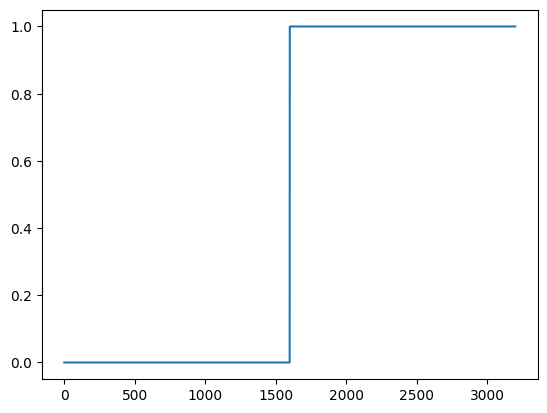

In [ ]:
plt.plot(y)

Text(0, 0.5, 'Power Spectrum')

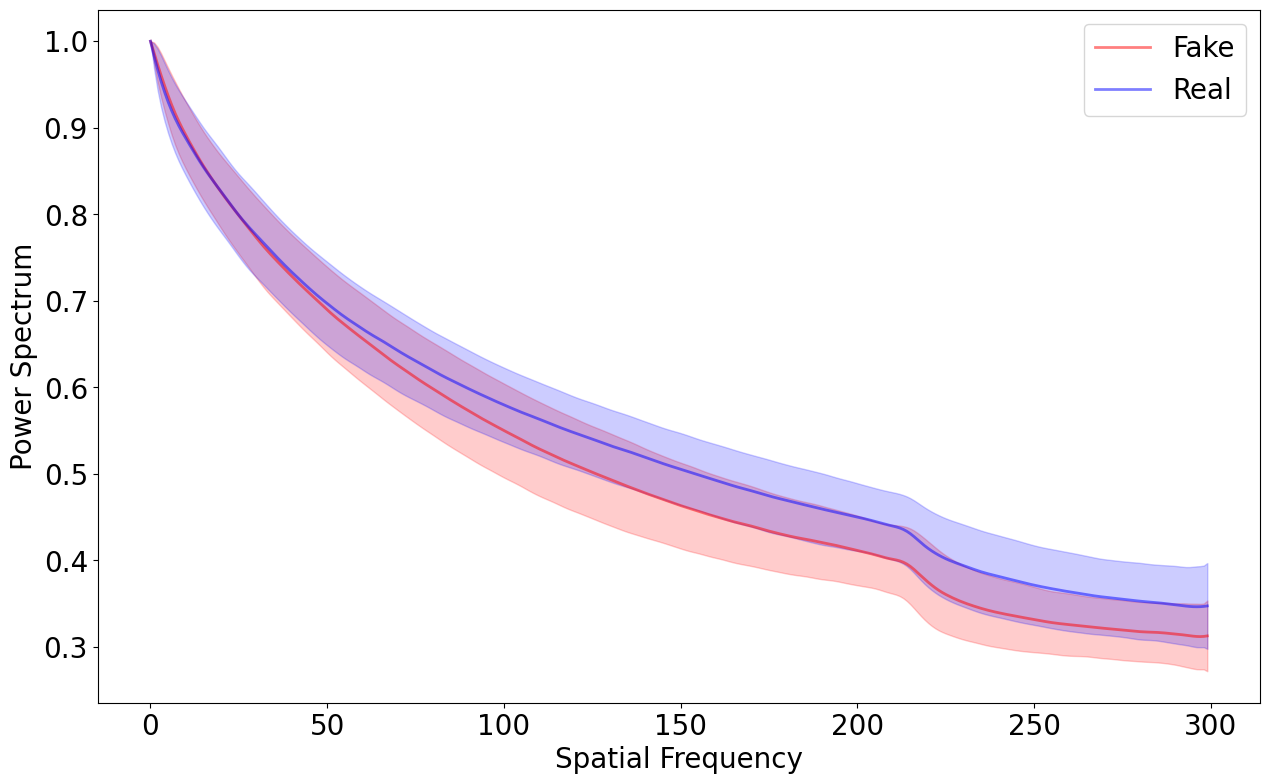

In [ ]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])

# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)

In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(psd1D_total_final, label_total_final, test_size=0.2, random_state=42)

# Train and evaluate machine learning models
# Example: Support Vector Machine (SVM)
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_accuracy = svm_model.score(X_test, y_test)
print("SVM Accuracy:", svm_accuracy)

# Example: Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
logreg_accuracy = logreg_model.score(X_test, y_test)
print("Logistic Regression Accuracy:", logreg_accuracy)

# Example: Artificial Neural Network (ANN) using TensorFlow
import tensorflow as tf

model_ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(N,)),
    tf.keras.layers.Dense(2, activation='softmax')
])
model_ann.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model_ann.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Example: Convolutional Neural Network (CNN) using TensorFlow
# You can use the same architecture as the previous example but reshape input data to 3D
X_train_cnn = X_train.reshape(-1, N, 1)
X_test_cnn = X_test.reshape(-1, N, 1)

model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(N, 1)),       # relu -> Rectified linear unit(doesn't allow activation of all neuron at the same time)
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')                              # Softmax - RAW o/p into vector of probabilities
])
model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model_cnn.fit(X_train_cnn, y_train, epochs=10, validation_data=(X_test_cnn, y_test))

# Example: Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_accuracy = rf_model.score(X_test, y_test)
print("Random Forest Accuracy:", rf_accuracy)



SVM Accuracy: 0.840625
Logistic Regression Accuracy: 0.8328125
Epoch 1/10
80/80 [==============================] - 1s 5ms/step - loss: 0.6824 - accuracy: 0.5711 - val_loss: 0.6520 - val_accuracy: 0.6781
Epoch 2/10
80/80 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.7117 - val_loss: 0.5778 - val_accuracy: 0.7781
Epoch 3/10
80/80 [==============================] - 0s 3ms/step - loss: 0.5910 - accuracy: 0.6871 - val_loss: 0.5754 - val_accuracy: 0.7156
Epoch 4/10
80/80 [==============================] - 0s 3ms/step - loss: 0.5369 - accuracy: 0.7574 - val_loss: 0.5413 - val_accuracy: 0.7031
Epoch 5/10
80/80 [==============================] - 0s 3ms/step - loss: 0.5369 - accuracy: 0.7477 - val_loss: 0.5594 - val_accuracy: 0.7188
Epoch 6/10
80/80 [==============================] - 0s 3ms/step - loss: 0.5122 - accuracy: 0.7660 - val_loss: 0.4978 - val_accuracy: 0.7812
Epoch 7/10
80/80 [==============================] - 0s 3ms/step - loss: 0.4986 - accuracy: 0.7758

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)

print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)
print("SVM Recall (Sensitivity):", svm_recall)
print("SVM F1-score:", svm_f1)

from sklearn.metrics import confusion_matrix

svm_conf_matrix = confusion_matrix(y_test, svm_pred)
print("SVM Confusion Matrix:")
print(svm_conf_matrix)


SVM Accuracy: 0.840625
SVM Precision: 0.8305084745762712
SVM Recall (Sensitivity): 0.8249158249158249
SVM F1-score: 0.8277027027027027
SVM Confusion Matrix:
[[293  50]
 [ 52 245]]


In [ ]:
logreg_pred = logreg_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_pred)
logreg_precision = precision_score(y_test, logreg_pred)
logreg_recall = recall_score(y_test, logreg_pred)
logreg_f1 = f1_score(y_test, logreg_pred)

print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Precision:", logreg_precision)
print("Logistic Regression Recall (Sensitivity):", logreg_recall)
print("Logistic Regression F1-score:", logreg_f1)

logreg_conf_matrix = confusion_matrix(y_test, logreg_pred)
print("Logistic Regression Confusion Matrix:")
print(logreg_conf_matrix)


Logistic Regression Accuracy: 0.8328125
Logistic Regression Precision: 0.8231292517006803
Logistic Regression Recall (Sensitivity): 0.8148148148148148
Logistic Regression F1-score: 0.8189509306260575
Logistic Regression Confusion Matrix:
[[291  52]
 [ 55 242]]


In [ ]:
# Predict class probabilities
ann_probabilities = model_ann.predict(X_test)
# Extract predicted classes
ann_pred = np.argmax(ann_probabilities, axis=1)

# Now compute accuracy, precision, recall, and F1-score as before
ann_accuracy = accuracy_score(y_test, ann_pred)
ann_precision = precision_score(y_test, ann_pred)
ann_recall = recall_score(y_test, ann_pred)
ann_f1 = f1_score(y_test, ann_pred)

print("ANN Accuracy:", ann_accuracy)
print("ANN Precision:", ann_precision)
print("ANN Recall (Sensitivity):", ann_recall)
print("ANN F1-score:", ann_f1)



ann_conf_matrix = confusion_matrix(y_test, ann_pred)
print("ANN Confusion Matrix:")
print(ann_conf_matrix)


20/20 [==============================] - 0s 2ms/step
ANN Accuracy: 0.80625
ANN Precision: 0.8035087719298246
ANN Recall (Sensitivity): 0.7710437710437711
ANN F1-score: 0.7869415807560138
ANN Confusion Matrix:
[[287  56]
 [ 68 229]]


In [ ]:
# Predict class probabilities
cnn_probabilities = model_cnn.predict(X_test_cnn)
# Extract predicted classes
cnn_pred = np.argmax(cnn_probabilities, axis=1)

# Now compute accuracy, precision, recall, and F1-score as before
cnn_accuracy = accuracy_score(y_test, cnn_pred)
cnn_precision = precision_score(y_test, cnn_pred)
cnn_recall = recall_score(y_test, cnn_pred)
cnn_f1 = f1_score(y_test, cnn_pred)

print("CNN Accuracy:", cnn_accuracy)
print("CNN Precision:", cnn_precision)
print("CNN Recall (Sensitivity):", cnn_recall)
print("CNN F1-score:", cnn_f1)

# Now compute and print confusion matrix
cnn_conf_matrix = confusion_matrix(y_test, cnn_pred)
print("CNN Confusion Matrix:")
print(cnn_conf_matrix)


20/20 [==============================] - 0s 12ms/step
CNN Accuracy: 0.7796875
CNN Precision: 0.7131147540983607
CNN Recall (Sensitivity): 0.8787878787878788
CNN F1-score: 0.7873303167420814
CNN Confusion Matrix:
[[238 105]
 [ 36 261]]


In [ ]:
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall (Sensitivity):", rf_recall)
print("Random Forest F1-score:", rf_f1)


rf_conf_matrix = confusion_matrix(y_test, rf_pred)
print("Random Forest Confusion Matrix:")
print(rf_conf_matrix)


Random Forest Accuracy: 0.9234375
Random Forest Precision: 0.9366197183098591
Random Forest Recall (Sensitivity): 0.8956228956228957
Random Forest F1-score: 0.9156626506024097
Random Forest Confusion Matrix:
[[325  18]
 [ 31 266]]


In [ ]:
import pickle

# Load the data
with open('/content/drive/MyDrive/Colab Notebooks/prepro_deepFake/train_3200.pkl', 'rb') as pkl_file:
    train_data = pickle.load(pkl_file)

# Extract the labels from the data
labels = train_data["label"]

# Check the unique classes
unique_classes = np.unique(labels)
num_classes = len(unique_classes)

print("Number of unique classes:", num_classes)
print("Unique classes:", unique_classes)


Number of unique classes: 2
Unique classes: [0. 1.]


In [ ]:
import cv2
import numpy as np
from scipy.interpolate import griddata
import pickle
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Function to compute azimuthal average
def azimuthal_average(image):
    cy, cx = np.array(image.shape) // 2
    y, x = np.indices(image.shape)
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    r_bins = np.arange(0, image.shape[0] // 2 + 1, 1)

    radial_sum = np.zeros_like(r_bins[:-1], dtype=float)
    radial_count = np.zeros_like(r_bins[:-1], dtype=int)

    for i in range(len(r_bins) - 1):
        mask = (r >= r_bins[i]) & (r < r_bins[i + 1])
        radial_sum[i] = np.sum(image[mask])
        radial_count[i] = np.sum(mask)

    radial_avg = radial_sum / (radial_count + 1e-8)
    return radial_avg

# Preprocess the single image
def preprocess_image(image_path):
    # Read the image
    img = cv2.imread(image_path, 0)

    # Crop the center
    h = int(img.shape[0] / 3)
    w = int(img.shape[1] / 3)
    img = img[h:-h, w:-w]

    # Compute FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))

    # Compute azimuthally averaged 1D power spectrum
    psd1D = azimuthal_average(magnitude_spectrum)

    # Interpolate and normalize
    N = 300  # Same as in the training code
    points = np.linspace(0, N, num=psd1D.size)
    xi = np.linspace(0, N, num=N)
    interpolated = griddata(points, psd1D, xi, method='cubic')
    interpolated /= interpolated[0]

    return interpolated.reshape(1, -1)

# Load trained models
with open('/content/drive/MyDrive/Colab Notebooks/soft_comp/train_3200.pkl', 'rb') as model_file:
    train_data = pickle.load(model_file)

X_train = train_data["data"]
y_train = train_data["label"]

# Train your models (SVM and Logistic Regression)
# Create and train SVM model
svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86, probability=True)  # Set probability to True
svclassifier_r.fit(X_train, y_train)

# Create and train Logistic Regression model
logreg = LogisticRegression(solver='liblinear', max_iter=1000)
logreg.fit(X_train, y_train)

# Create and train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Path to the image you want to classify
image_path = '/content/drive/MyDrive/Colab Notebooks/soft_comp/fake/01_04__meeting_serious__0XUW13RW/8409.jpg'

# Preprocess the image
processed_image = preprocess_image(image_path)

# Predict using the trained models
svm_prediction = svclassifier_r.predict(processed_image)
svm_probability = svclassifier_r.predict_proba(processed_image)

lr_prediction = logreg.predict(processed_image)
lr_probability = logreg.predict_proba(processed_image)

rf_prediction = rf_model.predict(processed_image)
rf_probability = rf_model.predict_proba(processed_image)

print("SVM Prediction:", "Real" if svm_prediction[0] == 1 else "Fake")
print("SVM Probability:", svm_probability)

print("LR Prediction:", "Real" if lr_prediction[0] == 1 else "Fake")
print("LR Probability:", lr_probability)

print("Random Forest Prediction:", "Real" if rf_prediction[0] == 1 else "Fake")
print("Random Forest Probability:", rf_probability)


SVM Prediction: Real
SVM Probability: [[0.07884019 0.92115981]]
LR Prediction: Real
LR Probability: [[0.49935321 0.50064679]]
Random Forest Prediction: Fake
Random Forest Probability: [[0.78 0.22]]
